In [83]:
#load libraries
library(ggplot2)
library("speedyseq")
library(microbiome)
library(phyloseq)
library("tidyverse")
library("dplyr")
library(vegan)
library("lubridate")
library('PCAtools')
library("DESeq2")
library("GGally")
library("ggpmisc")
library(patchwork)
library(ggtext)
library("ggcorrplot")
library("ggplotify")
library(microViz)
library(qiime2R)
library("MicrobiomeStat")
#library(ggpubr)
library(ggsignif)
library(lme4)
library(lmerTest)
library(multcomp)

In [12]:
#detach("package:ggpubr", unload = TRUE)

In [13]:
load("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/ps_unpruned.RData")
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 191539 taxa and 360 samples ]:
sample_data() Sample Data:        [ 360 samples by 13 sample variables ]:
tax_table()   Taxonomy Table:     [ 191539 taxa by 7 taxonomic ranks ]:
taxa are columns

In [14]:
#extract metadata file from phyloseq object 
meta=data.frame(sample_data(ps))  %>% as.data.frame() %>%
rownames_to_column("samp") %>%
mutate_at(vars(Sample.ID.file), 
             ~ stringr::str_replace_all(., pattern = "_S*", replacement = "")) %>%
mutate_at(vars(Sample.ID.file), 
            ~ stringr::str_replace_all(., pattern = "SWG", replacement = "")) %>%
column_to_rownames("Sample.ID.file")  %>%
  mutate(Site_Num = case_when(
    Site.Status == "Vulnerable" ~ 1,
    Site.Status == "Endemic" ~ 3,
    Site.Status == "Epidemic" ~ 2,
    TRUE ~ NA_integer_
  ))
meta$Site_Num <- as.integer(meta$Site_Num)
meta$Site.Status <- factor(meta$Site.Status, levels = c("Vulnerable",
                                                         "Epidemic","Endemic"))
head(meta)
dim(meta)

#write.csv(meta,"/Users/stephanie.rosales/Documents/Tissueloss/EPA2/meta_EPA2.csv")

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,Site.Status,Month,Year,Site_Num
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<int>,<int>
CG.DSTO1.H,CG.DSTO1.H_S3,CG.DSTO1.H_S3,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,Epidemic,February,2020,2
CG.DSTO3.H,CG.DSTO3.H_S3,CG.DSTO3.H_S3,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,Epidemic,February,2020,2
CG.DSTO4.H,CG.DSTO4.H_S3,CG.DSTO4.H_S3,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,Epidemic,February,2020,2
CG.DSTO5.H,CG.DSTO5.H_S3,CG.DSTO5.H_S3,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,Epidemic,February,2020,2
CG.DSTO6.H,CG.DSTO6.H_S3,CG.DSTO6.H_S3,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,Epidemic,February,2020,2
CG.SINT1.H,CG.SINT1.H_S3,CG.SINT1.H_S3,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,SINT,Healthy,Epidemic,February,2020,2


[1] 360  14

In [15]:
meta = read.csv("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/metadata/meta_EPA2.csv",
               header=TRUE, row.names=1)
meta$Site_Num <- as.integer(meta$Site_Num)
meta$Site.Status <- factor(meta$Site.Status, levels = c("Vulnerable",
                                                         "Epidemic","Endemic"))
head(meta)


,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
518.H,518.H_S18,518.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,OFAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
519.H,519.H_S18,519.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,OFAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
520.H,520.H_S18,520.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,OFAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
521.H,521.H_S18,521.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,MCAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
522.H,522.H_S18,522.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,MCAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
523.H,523.H_S18,523.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,MCAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0


In [16]:
ASV_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/merged_tables_BacArc_fill_EPA2.qza")
ASV_table <- ASV_qza$data
head(ASV_table)

dim(ASV_table)

,R1.1.W,R1.10.W,R1.11.W,R1.12.W,R1.13.W,R1.14.W,R1.15.W,R1.16.W,R1.17.W,R1.18.W,⋯,GR.SINT.En4,GR.SINT.En5,GR.SINT.En6,TP.DLAB.En1,TP.DLAB.En2,TP.DLAB.En3,TP.DLAB.En4,TP.DLAB.En5,TP.DLAB.En6,TP.DSTO.En1
72caa013fe7649c65ffe72138ff7dfd1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2b248f10cca3c82a2640506132f9c869,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4af34e31f4f29f5372246db273985eb8,12,18,24,19,20,28,21,23,19,26,⋯,0,0,38,0,197,37,149,198,14,0
516a7dfb3358a03ad54608b2bfe54ded,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
63c48fb71320865b89f020cc70ce9bae,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5ca9f99167b7bf31249f42965de904ff,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 11756  1109

In [17]:
taxa_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/tax_EPA2.qza")
taxa_table <- taxa_qza$data
taxa_table <- taxa_qza$data %>%
as_tibble() %>% 
#select(-Confidence) %>% 
separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>%
arrange(Feature.ID) %>%
mutate(ASVs =paste('ASV',1:n(), sep = "_")) %>%
column_to_rownames("Feature.ID")%>%
as.matrix()

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 103262 rows [1, 2, 3, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, ...].”


In [18]:
ps = phyloseq(otu_table(ASV_table, taxa_are_rows=TRUE), 
               sample_data(meta),
tax_table(taxa_table))
ps %>% tax_fix()


#filter to remove noise from data
ps_fill = filter_taxa(ps, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill 

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 360 samples ]:
sample_data() Sample Data:        [ 360 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 2041 taxa and 360 samples ]:
sample_data() Sample Data:        [ 360 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 2041 taxa by 9 taxonomic ranks ]:
taxa are rows

In [19]:
ps_coral= subset_samples(ps, Type=="Coral")
ps_coral_fill = filter_taxa(ps_coral, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_coral_fill 

# Subset samples healthy and then by species
ps_AH <- subset_samples(ps_coral, Sample.Type=="Healthy")

ps_AH_fill = filter_taxa(ps_AH, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_AH_fill 
                            
ps_ah_DSTO=subset_samples(ps_AH, Species_sample=="DSTO")
ps_ah_DSTO
ps_ah_SINT=subset_samples(ps_AH, Species_sample=="SINT")
ps_ah_SINT
ps_ah_MCAV=subset_samples(ps_AH, Species_sample=="MCAV")
ps_ah_MCAV
ps_ah_OFAV=subset_samples(ps_AH, Species_sample=="OFAV")
ps_ah_OFAV
ps_ah_PSTR=subset_samples(ps_AH, Species_sample=="PSTR")
ps_ah_PSTR

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1304 taxa and 174 samples ]:
sample_data() Sample Data:        [ 174 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 1304 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 915 taxa and 117 samples ]:
sample_data() Sample Data:        [ 117 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 915 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 16 samples ]:
sample_data() Sample Data:        [ 16 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 17 samples ]:
sample_data() Sample Data:        [ 17 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 28 samples ]:
sample_data() Sample Data:        [ 28 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 29 samples ]:
sample_data() Sample Data:        [ 29 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 27 samples ]:
sample_data() Sample Data:        [ 27 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

In [20]:
ps_fill_dsto = filter_taxa(ps_ah_DSTO, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_dsto
ps_fill_sint = filter_taxa(ps_ah_SINT, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_sint
ps_fill_mcav = filter_taxa(ps_ah_MCAV, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_mcav
ps_fill_ofav = filter_taxa(ps_ah_OFAV, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_ofav               
ps_fill_pstr = filter_taxa(ps_ah_PSTR, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_pstr                           

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1427 taxa and 16 samples ]:
sample_data() Sample Data:        [ 16 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 1427 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 2016 taxa and 17 samples ]:
sample_data() Sample Data:        [ 17 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 2016 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 535 taxa and 28 samples ]:
sample_data() Sample Data:        [ 28 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 535 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 805 taxa and 29 samples ]:
sample_data() Sample Data:        [ 29 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 805 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1222 taxa and 27 samples ]:
sample_data() Sample Data:        [ 27 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 1222 taxa by 9 taxonomic ranks ]:
taxa are rows

In [21]:
# Subset samples for Sediment type
ps_Sediment <- subset_samples(ps, subset = sample_data(ps)$Type == "Sediment")

ps_fill_s = filter_taxa(ps_Sediment, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_s

ps_Water <- subset_samples(ps, subset = sample_data(ps)$Type == "Water")

ps_fill_w = filter_taxa(ps_Water, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_w


phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 4389 taxa and 90 samples ]:
sample_data() Sample Data:        [ 90 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 4389 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 940 taxa and 96 samples ]:
sample_data() Sample Data:        [ 96 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 940 taxa by 9 taxonomic ranks ]:
taxa are rows

In [22]:
#filter 
ps_AH_fill_z= filter_taxa(ps_AH, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_AH_fill_z
                          

# find lowest ASV in sample
microbiome::summarize_phyloseq(ps_AH_fill_z)


ps_sed_z= filter_taxa(ps_Sediment, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_sed_z

microbiome::summarize_phyloseq(ps_sed_z)

ps_wat_z= filter_taxa(ps_Water, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_wat_z

microbiome::summarize_phyloseq(ps_wat_z)

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 7567 taxa and 117 samples ]:
sample_data() Sample Data:        [ 117 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 7567 taxa by 9 taxonomic ranks ]:
taxa are rows

Compositional = NO2

1] Min. number of reads = 46542] Max. number of reads = 3649503] Total number of reads = 117809744] Average number of reads = 100692.0854700855] Median number of reads = 866827] Sparsity = 0.9430331206464426] Any OTU sum to 1 or less? YES8] Number of singletons = 59] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)0.066076384300251110] Number of sample variables are: 32sampSample.IDSiteSite.NameRegionProjectObjectiveTypeSpecies_sampleSample.TypeSite.StatusMonthYearSite_NumDateVulnerableEpidemicEndemicSedimentCoralWaterZoneTypesVul_coralEnd_coralEpi_coralVul_sedEnd_sedEpi_sedVul_watEnd_watEpi_wat2



[[1]]
[1] "1] Min. number of reads = 4654"

[[2]]
[1] "2] Max. number of reads = 364950"

[[3]]
[1] "3] Total number of reads = 11780974"

[[4]]
[1] "4] Average number of reads = 100692.085470085"

[[5]]
[1] "5] Median number of reads = 86682"

[[6]]
[1] "7] Sparsity = 0.943033120646442"

[[7]]
[1] "6] Any OTU sum to 1 or less? YES"

[[8]]
[1] "8] Number of singletons = 5"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0.0660763843002511"

[[10]]
[1] "10] Number of sample variables are: 32"

[[11]]
 [1] "samp"           "Sample.ID"      "Site"           "Site.Name"     
 [5] "Region"         "Project"        "Objective"      "Type"          
 [9] "Species_sample" "Sample.Type"    "Site.Status"    "Month"         
[13] "Year"           "Site_Num"       "Date"           "Vulnerable"    
[17] "Epidemic"       "Endemic"        "Sediment"       "Coral"         
[21] "Water"          "Zone"           "Types"          "Vul_coral"     
[25] "End_coral"      "Epi_coral"      "Vul_sed"        "End_sed"       
[29] "Epi_sed"        "Vul_wat"        "End_wat"        "Epi_wat"

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 8675 taxa and 90 samples ]:
sample_data() Sample Data:        [ 90 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 8675 taxa by 9 taxonomic ranks ]:
taxa are rows

Compositional = NO2

1] Min. number of reads = 142942] Max. number of reads = 2550743] Total number of reads = 60820584] Average number of reads = 67578.42222222225] Median number of reads = 48401.57] Sparsity = 0.8050477105347426] Any OTU sum to 1 or less? NO8] Number of singletons = 09] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)010] Number of sample variables are: 32sampSample.IDSiteSite.NameRegionProjectObjectiveTypeSpecies_sampleSample.TypeSite.StatusMonthYearSite_NumDateVulnerableEpidemicEndemicSedimentCoralWaterZoneTypesVul_coralEnd_coralEpi_coralVul_sedEnd_sedEpi_sedVul_watEnd_watEpi_wat2



[[1]]
[1] "1] Min. number of reads = 14294"

[[2]]
[1] "2] Max. number of reads = 255074"

[[3]]
[1] "3] Total number of reads = 6082058"

[[4]]
[1] "4] Average number of reads = 67578.4222222222"

[[5]]
[1] "5] Median number of reads = 48401.5"

[[6]]
[1] "7] Sparsity = 0.805047710534742"

[[7]]
[1] "6] Any OTU sum to 1 or less? NO"

[[8]]
[1] "8] Number of singletons = 0"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0"

[[10]]
[1] "10] Number of sample variables are: 32"

[[11]]
 [1] "samp"           "Sample.ID"      "Site"           "Site.Name"     
 [5] "Region"         "Project"        "Objective"      "Type"          
 [9] "Species_sample" "Sample.Type"    "Site.Status"    "Month"         
[13] "Year"           "Site_Num"       "Date"           "Vulnerable"    
[17] "Epidemic"       "Endemic"        "Sediment"       "Coral"         
[21] "Water"          "Zone"           "Types"          "Vul_coral"     
[25] "End_coral"      "Epi_coral"      "Vul_sed"        "End_sed"       
[29] "Epi_sed"        "Vul_wat"        "End_wat"        "Epi_wat"

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 4499 taxa and 96 samples ]:
sample_data() Sample Data:        [ 96 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 4499 taxa by 9 taxonomic ranks ]:
taxa are rows

Compositional = NO2

1] Min. number of reads = 463532] Max. number of reads = 2935173] Total number of reads = 120776364] Average number of reads = 125808.7083333335] Median number of reads = 1328827] Sparsity = 0.886745665703496] Any OTU sum to 1 or less? YES8] Number of singletons = 19] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)0.022227161591464810] Number of sample variables are: 32sampSample.IDSiteSite.NameRegionProjectObjectiveTypeSpecies_sampleSample.TypeSite.StatusMonthYearSite_NumDateVulnerableEpidemicEndemicSedimentCoralWaterZoneTypesVul_coralEnd_coralEpi_coralVul_sedEnd_sedEpi_sedVul_watEnd_watEpi_wat2



[[1]]
[1] "1] Min. number of reads = 46353"

[[2]]
[1] "2] Max. number of reads = 293517"

[[3]]
[1] "3] Total number of reads = 12077636"

[[4]]
[1] "4] Average number of reads = 125808.708333333"

[[5]]
[1] "5] Median number of reads = 132882"

[[6]]
[1] "7] Sparsity = 0.88674566570349"

[[7]]
[1] "6] Any OTU sum to 1 or less? YES"

[[8]]
[1] "8] Number of singletons = 1"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0.0222271615914648"

[[10]]
[1] "10] Number of sample variables are: 32"

[[11]]
 [1] "samp"           "Sample.ID"      "Site"           "Site.Name"     
 [5] "Region"         "Project"        "Objective"      "Type"          
 [9] "Species_sample" "Sample.Type"    "Site.Status"    "Month"         
[13] "Year"           "Site_Num"       "Date"           "Vulnerable"    
[17] "Epidemic"       "Endemic"        "Sediment"       "Coral"         
[21] "Water"          "Zone"           "Types"          "Vul_coral"     
[25] "End_coral"      "Epi_coral"      "Vul_sed"        "End_sed"       
[29] "Epi_sed"        "Vul_wat"        "End_wat"        "Epi_wat"

In [23]:
ps_AH_rare <- phyloseq::rarefy_even_depth(ps_AH_fill_z, rngseed = 123, replace = FALSE, sample.size=4654)          


`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

1767OTUs were removed because they are no longer 
present in any sample after random subsampling


...



,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3S7A1,R3S7A1_S11,R3S7A1_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A2,R3S7A2_S11,R3S7A2_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A3,R3S7A3_S11,R3S7A3_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A4,R3S7A4_S11,R3S7A4_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A5,R3S7A5_S11,R3S7A5_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7C1,R3S7C1_S12,R3S7C1_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,SINT,Healthy,⋯,0,1,0,0,0,0,0,0,0,0


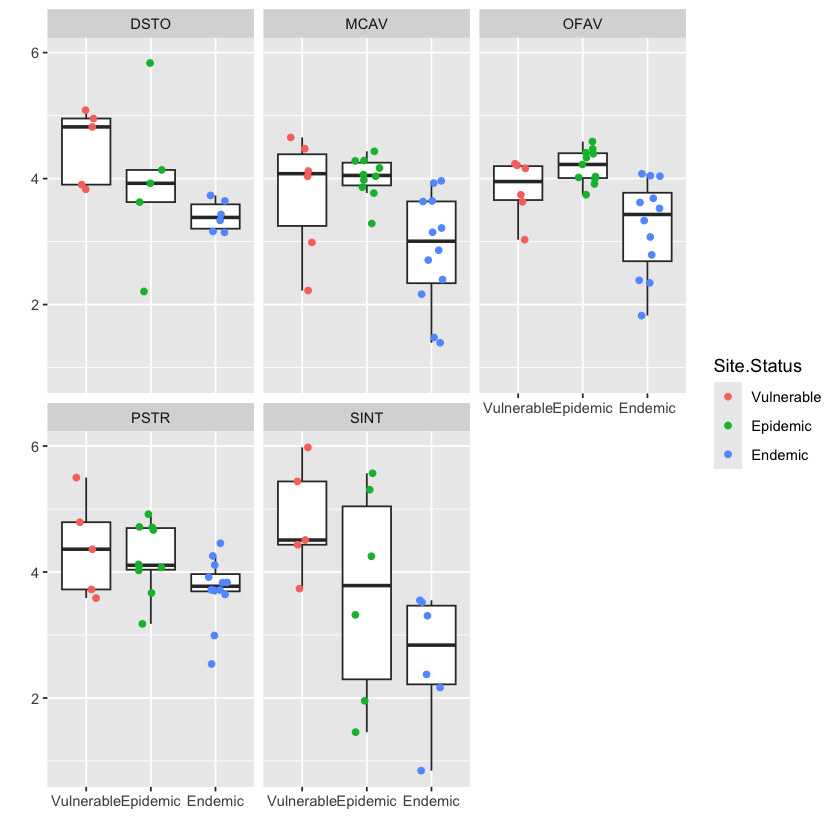

In [24]:
adiv_AH_z <- data.frame(
  "Shannon" = phyloseq::estimate_richness(ps_AH_rare, measures = "Shannon"))


#combine data with enviornmental data
ps_AH_rare_meta= as(sample_data(ps_AH_rare), "data.frame")

head(ps_AH_rare_meta)

alpha_envs_AH_rare=cbind(ps_AH_rare_meta, adiv_AH_z)

alpha_envs_AH_rare %>%
 ggplot(aes(x = Site.Status, y = Shannon))  +
  geom_boxplot(outlier.color = NA)  +
geom_jitter(aes(color = Site.Status), height = 0, width = .2) +
  labs(x = "", y = "") +
facet_wrap(.~Species_sample)



	Shapiro-Wilk normality test

data:  adiv_AH_z$Shannon
W = 0.9624, p-value = 0.002332


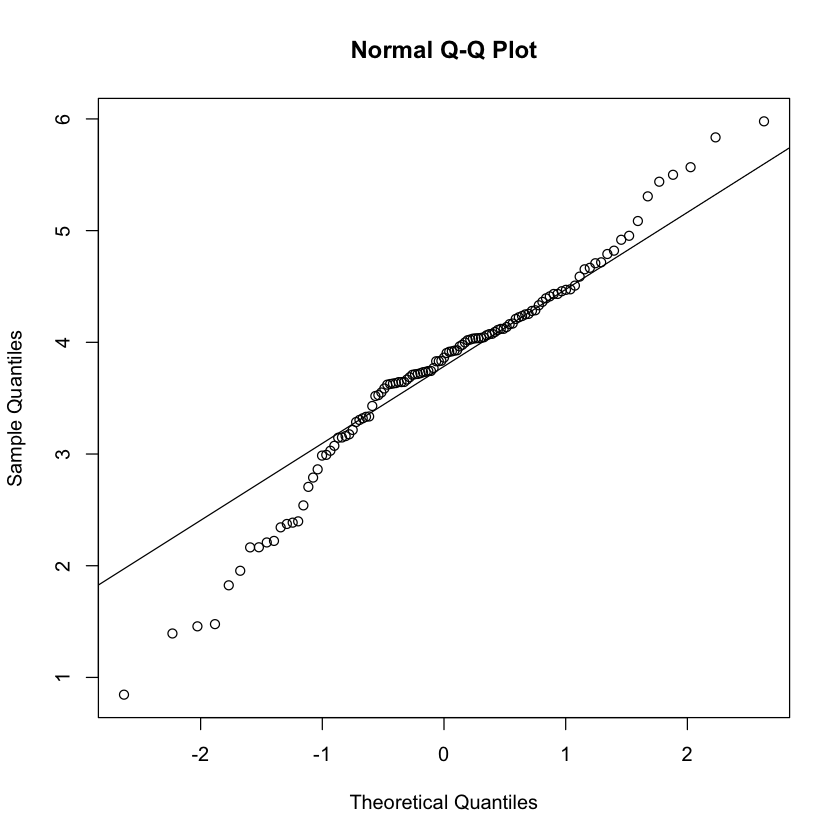

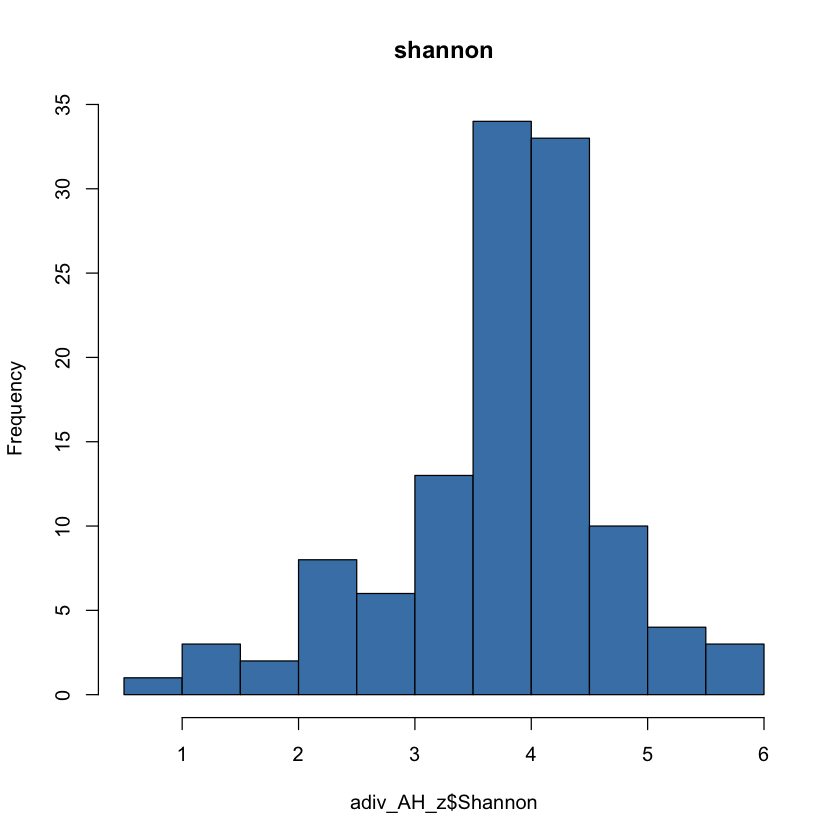

In [25]:
#inspect normalized data
qqnorm(adiv_AH_z$Shannon)
qqline(adiv_AH_z$Shannon)
shapiro.test(adiv_AH_z$Shannon)
hist(adiv_AH_z$Shannon, col='steelblue', main='shannon')

,Shannon,Shannon_trans
,<dbl>,<dbl>
R3S7A1,5.085976,1.4519698
R3S7A2,3.830418,0.0903059
R3S7A3,4.820535,1.1640967
R3S7A4,3.903985,0.1700894
R3S7A5,4.953705,1.3085202
R3S7C1,4.507851,0.8249875



	Shapiro-Wilk normality test

data:  adiv_trans$Shannon_trans
W = 0.9624, p-value = 0.002332


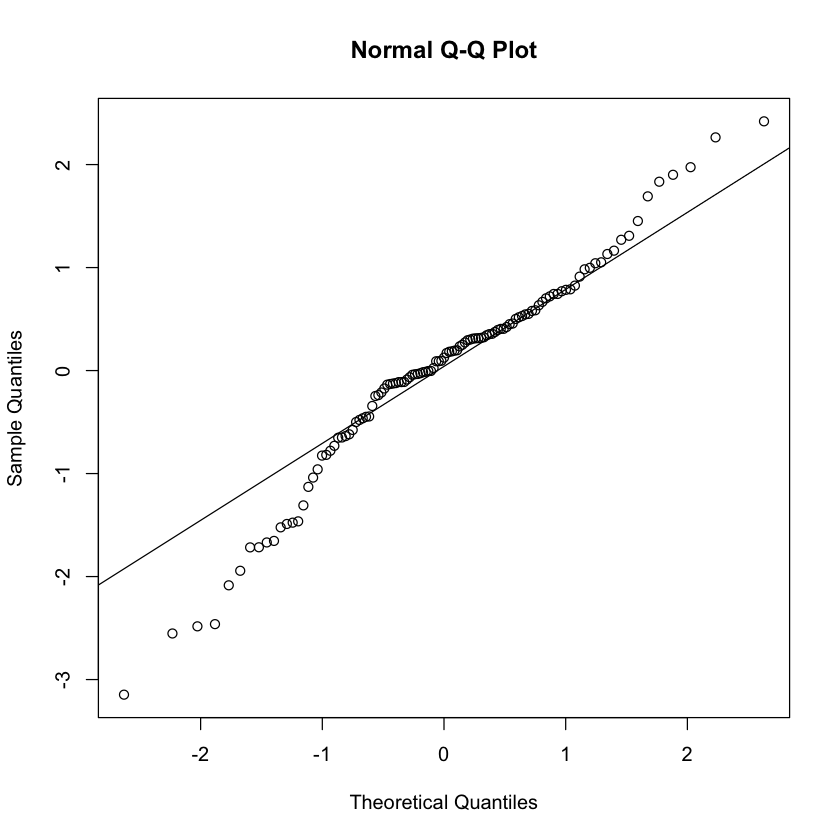

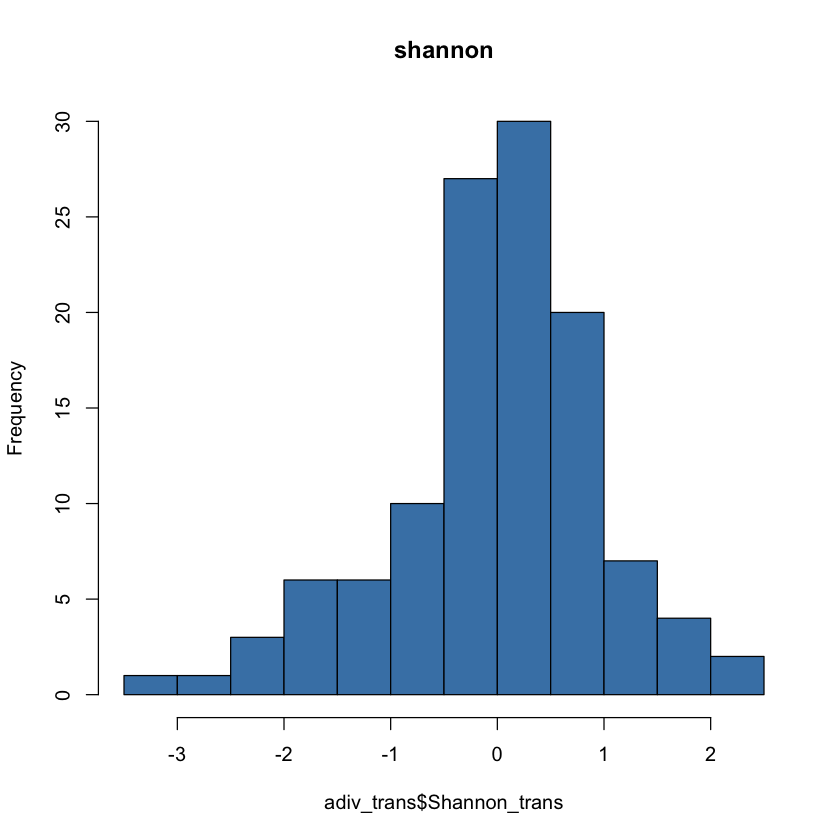

In [26]:
#normalize the data
adiv_trans =adiv_AH_z %>%
mutate(Shannon_trans = (Shannon - mean(Shannon)) / sd(Shannon))
head(adiv_trans)



#inspect normalized data
qqnorm(adiv_trans$Shannon_trans)
qqline(adiv_trans$Shannon_trans)
shapiro.test(adiv_trans$Shannon_trans)
hist(adiv_trans$Shannon_trans, col='steelblue', main='shannon')

In [27]:
library(ggpubr)
my_comparisons = list( c("Vulnerable", "Epidemic"), c("Vulnerable", "Endemic"), c("Endemic", "Epidemic") )



Attaching package: ‘ggpubr’


The following object is masked from ‘package:qiime2R’:

    mean_sd


The following object is masked from ‘package:microViz’:

    stat_chull




Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”


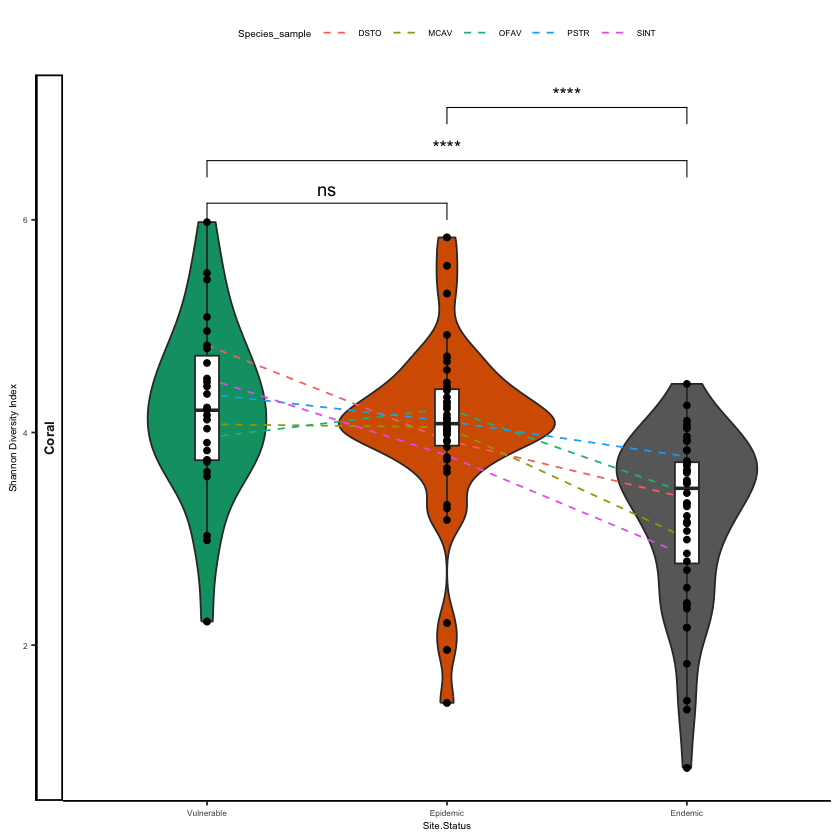

In [28]:
cbPalette <- c( "#009E73","#D55E00","#696969")
Fig_alpha_c=ggplot(alpha_envs_AH_rare,
       aes(x=Site.Status, y=Shannon)) +
geom_violin(aes(fill=Site.Status)) +
stat_summary(
    fun.y = median,
    geom = 'line',
    linetype = "dashed",
    aes(group = Species_sample, color=Species_sample)
    #position = position_dodge(width = 0.9)  #this has to be added
  ) +
geom_boxplot(width=0.1)+
geom_point() +
scale_fill_manual(values = cbPalette) +
theme_linedraw() +
#facet_wrap("Species_sample") +
theme_classic() +
facet_grid(Type~., switch="y") +
ylab("Shannon Diversity Index") +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
guides(fill = "none",  shape = "none") +
theme(legend.position="top") +
 theme(strip.text = element_text(
    size = 6)) +
 theme(strip.text = element_text(
    size = 8, face="bold")) +
#theme(strip.background=element_rect(fill=NA, color=NA)) +
 stat_compare_means(comparisons = my_comparisons,label.y = c(5.9, 6.3, 6.8
                                                             ), aes(label = after_stat(p.signif)))
Fig_alpha_c


In [50]:
ps_rare_w <- phyloseq::rarefy_even_depth(ps_wat_z, rngseed = 123, replace = FALSE, sample.size=46353)         

`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

396OTUs were removed because they are no longer 
present in any sample after random subsampling


...



,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3.1.W,R3.1.W_S14,R3.1.W_S14,NA,Cliff.Green,Lower Keys,EPA1,water,Water,Water,NA,⋯,2,0,0,0,0,0,0,1,0,0
R3.10.W,R3.10.W_S14,R3.10.W_S14,NA,Cliff.Green,Lower Keys,EPA1,water,Water,Water,NA,⋯,2,0,0,0,0,0,0,1,0,0
R3.11.W,R3.11.W_S14,R3.11.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,water,Water,Water,NA,⋯,2,0,0,0,0,0,0,1,0,0
R3.12.W,R3.12.W_S14,R3.12.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,water,Water,Water,NA,⋯,2,0,0,0,0,0,0,1,0,0
R3.13.W,R3.13.W_S14,R3.13.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,water,Water,Water,NA,⋯,2,0,0,0,0,0,0,1,0,0
R3.14.W,R3.14.W_S14,R3.14.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,water,Water,Water,NA,⋯,2,0,0,0,0,0,0,1,0,0


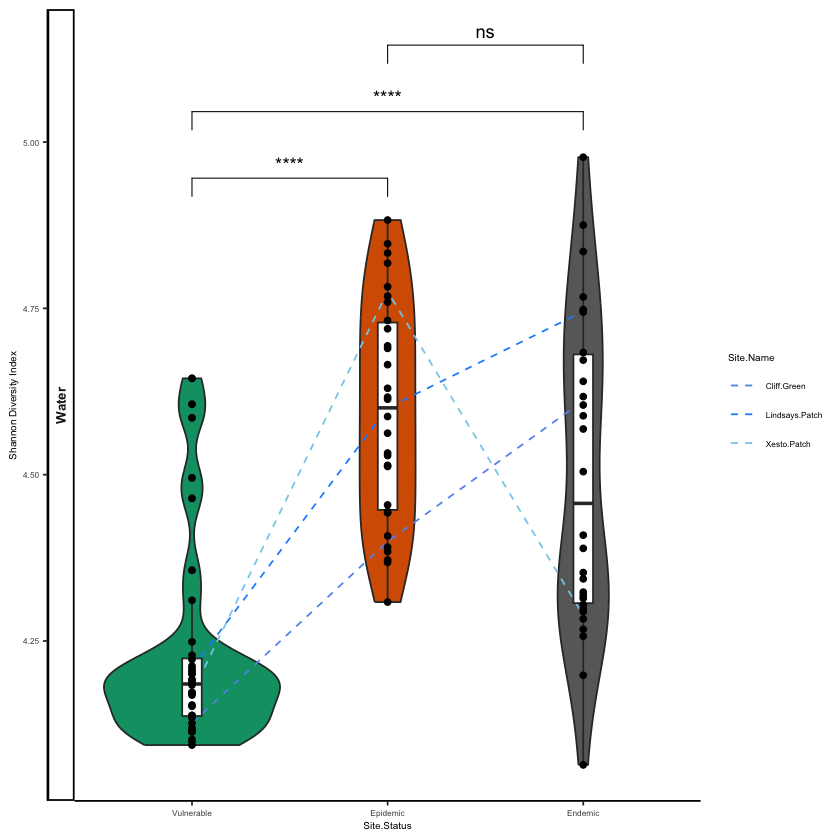

In [51]:
adiv_w_z <- data.frame(
  "Shannon" = phyloseq::estimate_richness(ps_rare_w, measures = "Shannon"))


#combine data with enviornmental data
ps_rare_w_meta= as(sample_data(ps_rare_w), "data.frame")

head(ps_rare_w_meta)

alpha_w_rare=cbind(ps_rare_w_meta, adiv_w_z)


Fig_alpha_w=ggplot(alpha_w_rare,
       aes(x=Site.Status, y=Shannon)) +
geom_violin(aes(fill=Site.Status)) +
stat_summary(
    fun.y = median,
    geom = 'line',
    linetype = "dashed",
    aes(group = Site.Name, color=Site.Name)
    #position = position_dodge(width = 0.9)  #this has to be added
  ) +
scale_color_manual(values=c( "#6495ED", "#1E90FF" ,"#87CEEB"
                          )) +
geom_boxplot(width=0.1)+
geom_point() +
scale_fill_manual(values = cbPalette) +
theme_linedraw() +
#facet_wrap("Species_sample") +
theme_classic() +
facet_grid(Type~.,  switch="y") +
ylab("Shannon Diversity Index") +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
guides(fill = "none",  shape = "none") +
 theme(strip.text = element_text(
    size = 8, face="bold")) +
#theme(strip.background=element_rect(fill=NA, color=NA)) +
 stat_compare_means(comparisons = my_comparisons, label.y = c(4.9, 5., 5.1), aes(label = after_stat(p.signif)))

Fig_alpha_w

In [31]:
ps_rare_s <- phyloseq::rarefy_even_depth(ps_sed_z, rngseed = 123, replace = FALSE, sample.size=14294)         

`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

193OTUs were removed because they are no longer 
present in any sample after random subsampling


...



,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3.1.S,R3.1.S_S13,R3.1.S_S13,NA,Cliff.Green,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,3,0,0,0,1,0,0,0,0,0
R3.10.S,R3.10.S_S13,R3.10.S_S13,NA,Cliff.Green,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,3,0,0,0,1,0,0,0,0,0
R3.11.S,R3.11.S_S13,R3.11.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,3,0,0,0,1,0,0,0,0,0
R3.12.S,R3.12.S_S13,R3.12.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,3,0,0,0,1,0,0,0,0,0
R3.13.S,R3.13.S_S13,R3.13.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,3,0,0,0,1,0,0,0,0,0
R3.14.S,R3.14.S_S13,R3.14.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,3,0,0,0,1,0,0,0,0,0


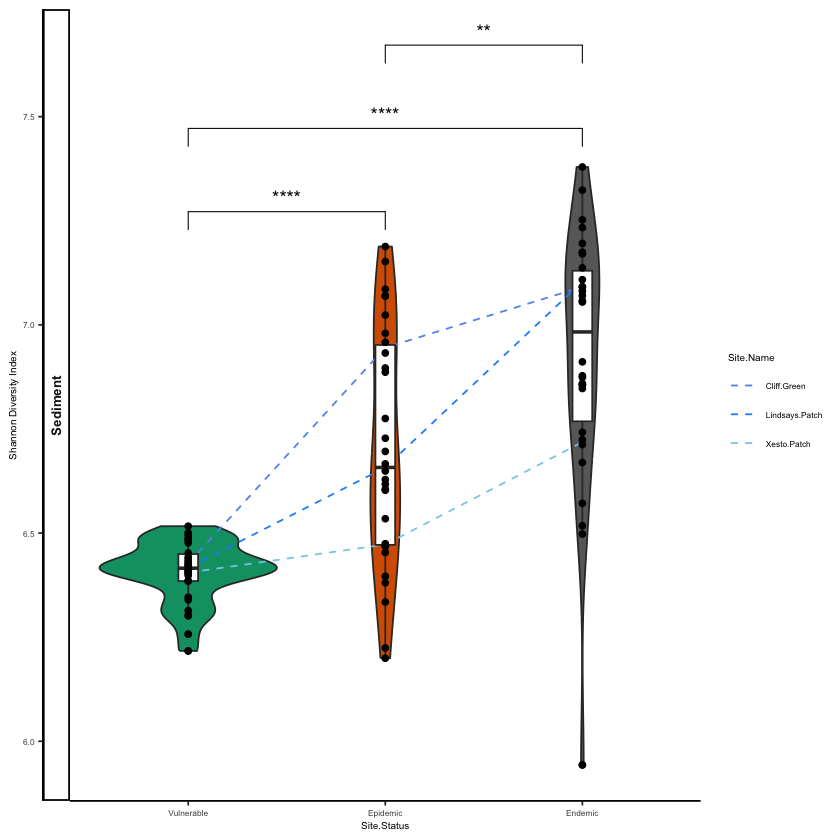

In [32]:
adiv_s_z <- data.frame(
  "Shannon" = phyloseq::estimate_richness(ps_rare_s, measures = "Shannon"))


#combine data with enviornmental data
ps_rare_s_meta= as(sample_data(ps_sed_z), "data.frame")

head(ps_rare_s_meta)

alpha_s_rare=cbind(ps_rare_s_meta, adiv_s_z)


Fig_alpha_s=ggplot(alpha_s_rare,
       aes(x=Site.Status, y=Shannon)) +
geom_violin(aes(fill=Site.Status)) +
stat_summary(
    fun.y = median,
    geom = 'line',
    linetype = "dashed",
    aes(group = Site.Name, color=Site.Name)
    #position = position_dodge(width = 0.9)  #this has to be added
  ) +
scale_color_manual(values=c( "#6495ED", "#1E90FF" ,"#87CEEB"
                          )) +
geom_boxplot(width=0.1)+
geom_point() +
scale_fill_manual(values = cbPalette) +
theme_linedraw() +
#facet_wrap("Species_sample") +
theme_classic() +
facet_grid(Type~., , switch="y") +
ylab("Shannon Diversity Index") +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
 guides(fill = "none",  shape = "none") +
 theme(strip.text = element_text(
       size = 8, face="bold")) +
#theme(strip.background=element_rect(fill=NA, color=NA)) +
 stat_compare_means(comparisons = my_comparisons, label.y = c(7.2, 7.4, 7.6), aes(label = after_stat(p.signif)),label = NULL)

Fig_alpha_s

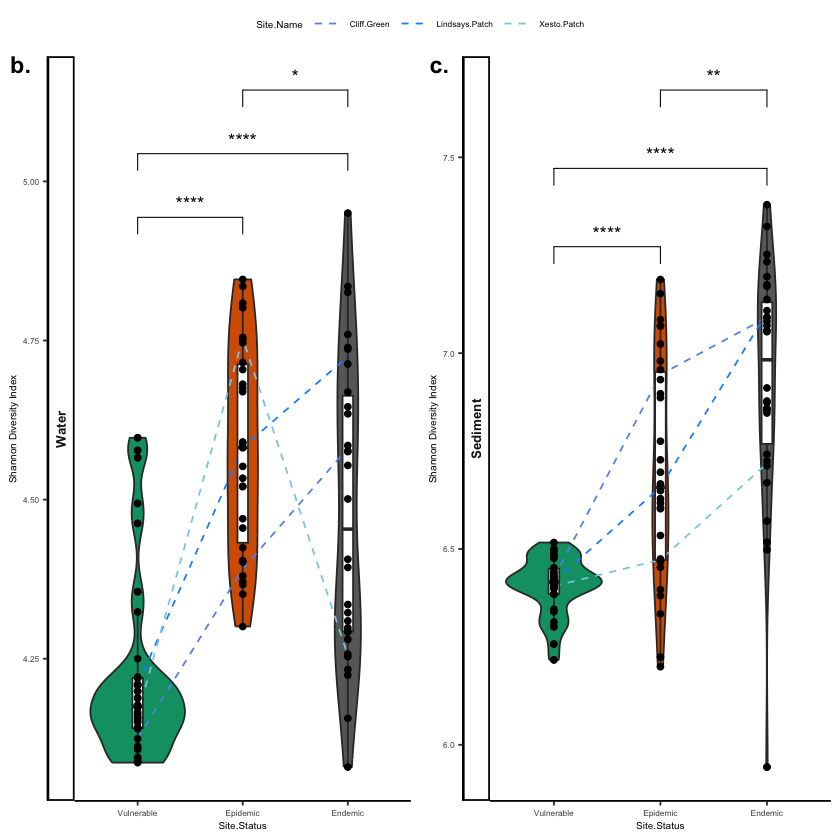

In [33]:
Fig_w_s=ggarrange( Fig_alpha_w, Fig_alpha_s, nrow = 1, ncol=2, common.legend = TRUE, legend="top",
                           labels = c("b.","c."))
Fig_w_s

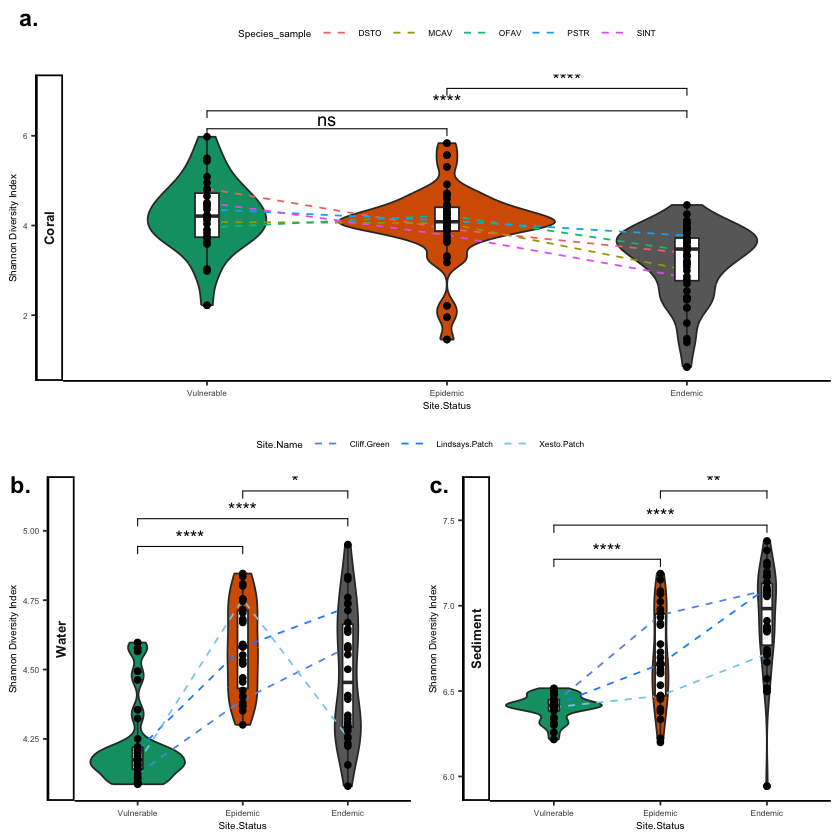

In [34]:
ggarrange(Fig_alpha_c, Fig_w_s, nrow = 2, ncol=1, common.legend = FALSE, legend="top",
                           labels = c(" a."))
ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/alpha.png",
     width = 6, height = 8, units = "in", dpi=300)
     


In [35]:
adiv <- data.frame(
  "Shannon" = phyloseq::estimate_richness(ps_AH_fill, measures = "Shannon"))
ps_AH_fill_meta= as(sample_data(ps_AH_fill), "data.frame")
alpha_envs=cbind(ps_AH_fill_meta, adiv)

In [36]:
#combine data with enviornmental data
ps_AH_fill_meta= as(sample_data(ps_AH_fill), "data.frame")

head(ps_AH_fill_meta)

alpha_envs=cbind(ps_AH_fill_meta, adiv)


,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3S7A1,R3S7A1_S11,R3S7A1_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A2,R3S7A2_S11,R3S7A2_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A3,R3S7A3_S11,R3S7A3_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A4,R3S7A4_S11,R3S7A4_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A5,R3S7A5_S11,R3S7A5_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7C1,R3S7C1_S12,R3S7C1_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,SINT,Healthy,⋯,0,1,0,0,0,0,0,0,0,0


In [37]:

ps_ah_DSTO_z= filter_taxa(ps_ah_DSTO, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_ah_DSTO_z  

ps_ah_SINT_z= filter_taxa(ps_ah_SINT, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_ah_SINT_z                            

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 3834 taxa and 16 samples ]:
sample_data() Sample Data:        [ 16 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 3834 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 4541 taxa and 17 samples ]:
sample_data() Sample Data:        [ 17 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 4541 taxa by 9 taxonomic ranks ]:
taxa are rows

In [38]:
microbiome::summarize_phyloseq(ps_AH_fill_z)

Compositional = NO2

1] Min. number of reads = 46542] Max. number of reads = 3649503] Total number of reads = 117809744] Average number of reads = 100692.0854700855] Median number of reads = 866827] Sparsity = 0.9430331206464426] Any OTU sum to 1 or less? YES8] Number of singletons = 59] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)0.066076384300251110] Number of sample variables are: 32sampSample.IDSiteSite.NameRegionProjectObjectiveTypeSpecies_sampleSample.TypeSite.StatusMonthYearSite_NumDateVulnerableEpidemicEndemicSedimentCoralWaterZoneTypesVul_coralEnd_coralEpi_coralVul_sedEnd_sedEpi_sedVul_watEnd_watEpi_wat2



[[1]]
[1] "1] Min. number of reads = 4654"

[[2]]
[1] "2] Max. number of reads = 364950"

[[3]]
[1] "3] Total number of reads = 11780974"

[[4]]
[1] "4] Average number of reads = 100692.085470085"

[[5]]
[1] "5] Median number of reads = 86682"

[[6]]
[1] "7] Sparsity = 0.943033120646442"

[[7]]
[1] "6] Any OTU sum to 1 or less? YES"

[[8]]
[1] "8] Number of singletons = 5"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0.0660763843002511"

[[10]]
[1] "10] Number of sample variables are: 32"

[[11]]
 [1] "samp"           "Sample.ID"      "Site"           "Site.Name"     
 [5] "Region"         "Project"        "Objective"      "Type"          
 [9] "Species_sample" "Sample.Type"    "Site.Status"    "Month"         
[13] "Year"           "Site_Num"       "Date"           "Vulnerable"    
[17] "Epidemic"       "Endemic"        "Sediment"       "Coral"         
[21] "Water"          "Zone"           "Types"          "Vul_coral"     
[25] "End_coral"      "Epi_coral"      "Vul_sed"        "End_sed"       
[29] "Epi_sed"        "Vul_wat"        "End_wat"        "Epi_wat"

In [39]:
microbiome::summarize_phyloseq(ps_ah_DSTO_z)
microbiome::summarize_phyloseq(ps_ah_SINT_z)

Compositional = NO2

1] Min. number of reads = 152092] Max. number of reads = 3060753] Total number of reads = 14281744] Average number of reads = 89260.8755] Median number of reads = 477297] Sparsity = 0.8587147887323946] Any OTU sum to 1 or less? YES8] Number of singletons = 19] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)0.026082420448617610] Number of sample variables are: 32sampSample.IDSiteSite.NameRegionProjectObjectiveTypeSpecies_sampleSample.TypeSite.StatusMonthYearSite_NumDateVulnerableEpidemicEndemicSedimentCoralWaterZoneTypesVul_coralEnd_coralEpi_coralVul_sedEnd_sedEpi_sedVul_watEnd_watEpi_wat2



[[1]]
[1] "1] Min. number of reads = 15209"

[[2]]
[1] "2] Max. number of reads = 306075"

[[3]]
[1] "3] Total number of reads = 1428174"

[[4]]
[1] "4] Average number of reads = 89260.875"

[[5]]
[1] "5] Median number of reads = 47729"

[[6]]
[1] "7] Sparsity = 0.858714788732394"

[[7]]
[1] "6] Any OTU sum to 1 or less? YES"

[[8]]
[1] "8] Number of singletons = 1"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0.0260824204486176"

[[10]]
[1] "10] Number of sample variables are: 32"

[[11]]
 [1] "samp"           "Sample.ID"      "Site"           "Site.Name"     
 [5] "Region"         "Project"        "Objective"      "Type"          
 [9] "Species_sample" "Sample.Type"    "Site.Status"    "Month"         
[13] "Year"           "Site_Num"       "Date"           "Vulnerable"    
[17] "Epidemic"       "Endemic"        "Sediment"       "Coral"         
[21] "Water"          "Zone"           "Types"          "Vul_coral"     
[25] "End_coral"      "Epi_coral"      "Vul_sed"        "End_sed"       
[29] "Epi_sed"        "Vul_wat"        "End_wat"        "Epi_wat"

Compositional = NO2

1] Min. number of reads = 412242] Max. number of reads = 2047703] Total number of reads = 19511644] Average number of reads = 114774.3529411765] Median number of reads = 1087437] Sparsity = 0.8346956487946426] Any OTU sum to 1 or less? YES8] Number of singletons = 59] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)0.11010790574763310] Number of sample variables are: 32sampSample.IDSiteSite.NameRegionProjectObjectiveTypeSpecies_sampleSample.TypeSite.StatusMonthYearSite_NumDateVulnerableEpidemicEndemicSedimentCoralWaterZoneTypesVul_coralEnd_coralEpi_coralVul_sedEnd_sedEpi_sedVul_watEnd_watEpi_wat2



[[1]]
[1] "1] Min. number of reads = 41224"

[[2]]
[1] "2] Max. number of reads = 204770"

[[3]]
[1] "3] Total number of reads = 1951164"

[[4]]
[1] "4] Average number of reads = 114774.352941176"

[[5]]
[1] "5] Median number of reads = 108743"

[[6]]
[1] "7] Sparsity = 0.834695648794642"

[[7]]
[1] "6] Any OTU sum to 1 or less? YES"

[[8]]
[1] "8] Number of singletons = 5"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0.110107905747633"

[[10]]
[1] "10] Number of sample variables are: 32"

[[11]]
 [1] "samp"           "Sample.ID"      "Site"           "Site.Name"     
 [5] "Region"         "Project"        "Objective"      "Type"          
 [9] "Species_sample" "Sample.Type"    "Site.Status"    "Month"         
[13] "Year"           "Site_Num"       "Date"           "Vulnerable"    
[17] "Epidemic"       "Endemic"        "Sediment"       "Coral"         
[21] "Water"          "Zone"           "Types"          "Vul_coral"     
[25] "End_coral"      "Epi_coral"      "Vul_sed"        "End_sed"       
[29] "Epi_sed"        "Vul_wat"        "End_wat"        "Epi_wat"

In [40]:
ps_AH_rare <- phyloseq::rarefy_even_depth(ps_ah_DSTO_z, rngseed = 123, replace = FALSE, sample.size=15209)          


`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

599OTUs were removed because they are no longer 
present in any sample after random subsampling


...



In [41]:
ps_AH_rare <- phyloseq::rarefy_even_depth(ps_ah_SINT_z, rngseed = 123, replace = FALSE, sample.size=41224)          


`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

123OTUs were removed because they are no longer 
present in any sample after random subsampling


...



,Shannon
,<dbl>
R3S7A1,4.849679
R3S7A2,3.965664
R3S7A3,5.155122
R3S7A4,3.691243
R3S7A5,4.492383
R3S7C1,4.570272


,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3S7A1,R3S7A1_S11,R3S7A1_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A2,R3S7A2_S11,R3S7A2_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A3,R3S7A3_S11,R3S7A3_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A4,R3S7A4_S11,R3S7A4_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A5,R3S7A5_S11,R3S7A5_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
CG.DSTO.En1,CG.DSTO.En1_S6,CG.DSTO.En1_S6,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,⋯,0,0,1,0,0,0,0,0,0,0


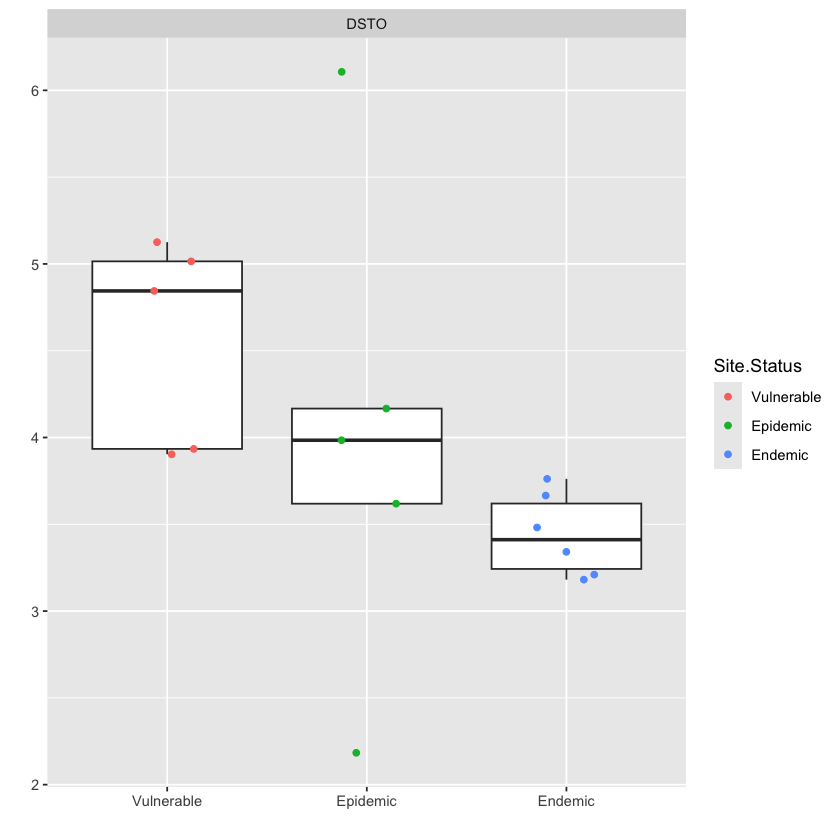

In [42]:
adiv_AH_z <- data.frame(
  "Shannon" = phyloseq::estimate_richness(ps_ah_DSTO_z, measures = "Shannon"))
head(adiv)

#combine data with enviornmental data
ps_AH_rare_meta= as(sample_data(ps_ah_DSTO_z), "data.frame")

head(ps_AH_rare_meta)

alpha_envs_AH_rare=cbind(ps_AH_rare_meta, adiv_AH_z)


alpha_envs_AH_rare %>%
 ggplot(aes(x = Site.Status, y = Shannon))  +
  geom_boxplot(outlier.color = NA)  +
geom_jitter(aes(color = Site.Status), height = 0, width = .2) +
  labs(x = "", y = "") +
facet_wrap(.~Species_sample)


,Shannon
,<dbl>
R3S7A1,4.849679
R3S7A2,3.965664
R3S7A3,5.155122
R3S7A4,3.691243
R3S7A5,4.492383
R3S7C1,4.570272


,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3S7C1,R3S7C1_S12,R3S7C1_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,SINT,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7C2,R3S7C2_S12,R3S7C2_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,SINT,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7C3,R3S7C3_S12,R3S7C3_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,SINT,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7C4,R3S7C4_S12,R3S7C4_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,SINT,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7C5,R3S7C5_S12,R3S7C5_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,SINT,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
CG.SINT.En1,CG.SINT.En1_S6,CG.SINT.En1_S6,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,SINT,Healthy,⋯,0,0,1,0,0,0,0,0,0,0


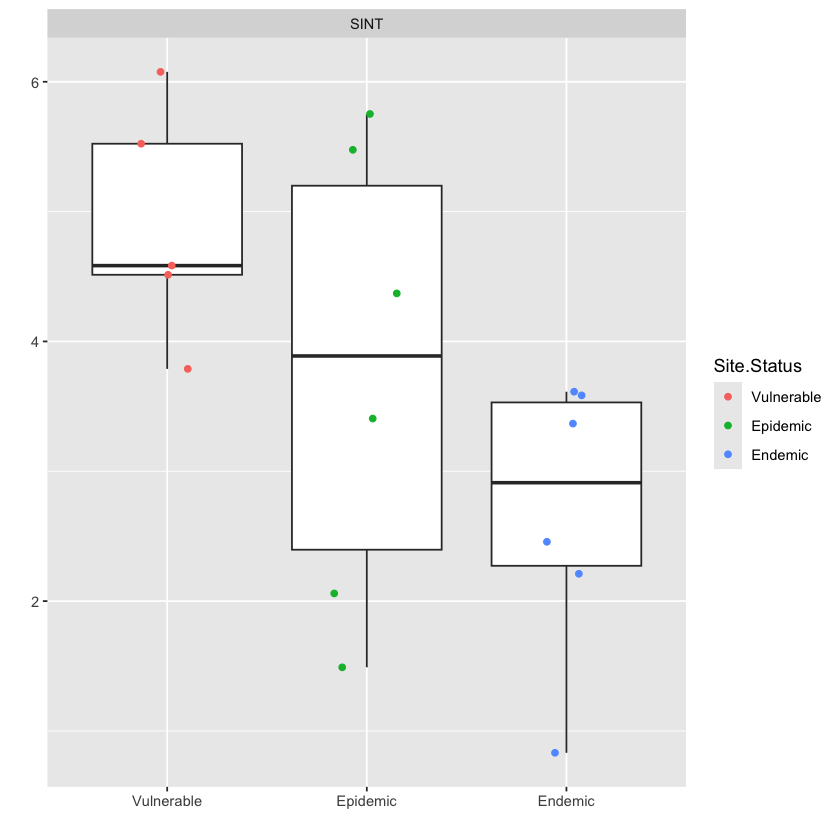

In [43]:
adiv_AH_z <- data.frame(
  "Shannon" = phyloseq::estimate_richness(ps_ah_SINT_z, measures = "Shannon"))
head(adiv)

#combine data with enviornmental data
ps_AH_rare_meta= as(sample_data(ps_ah_SINT_z), "data.frame")

head(ps_AH_rare_meta)

alpha_envs_AH_rare=cbind(ps_AH_rare_meta, adiv_AH_z)


alpha_envs_AH_rare %>%
 ggplot(aes(x = Site.Status, y = Shannon))  +
  geom_boxplot(outlier.color = NA)  +
geom_jitter(aes(color = Site.Status), height = 0, width = .2) +
  labs(x = "", y = "") +
facet_wrap(.~Species_sample)


In [44]:
ps_AH_rare <- phyloseq::rarefy_even_depth(ps_AH_fill_z, rngseed = 123, replace = FALSE, sample.size=4654)          


`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

1767OTUs were removed because they are no longer 
present in any sample after random subsampling


...



,Shannon
,<dbl>
R3S7A1,4.849679
R3S7A2,3.965664
R3S7A3,5.155122
R3S7A4,3.691243
R3S7A5,4.492383
R3S7C1,4.570272


,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3S7A1,R3S7A1_S11,R3S7A1_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A2,R3S7A2_S11,R3S7A2_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A3,R3S7A3_S11,R3S7A3_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A4,R3S7A4_S11,R3S7A4_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A5,R3S7A5_S11,R3S7A5_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7C1,R3S7C1_S12,R3S7C1_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,SINT,Healthy,⋯,0,1,0,0,0,0,0,0,0,0


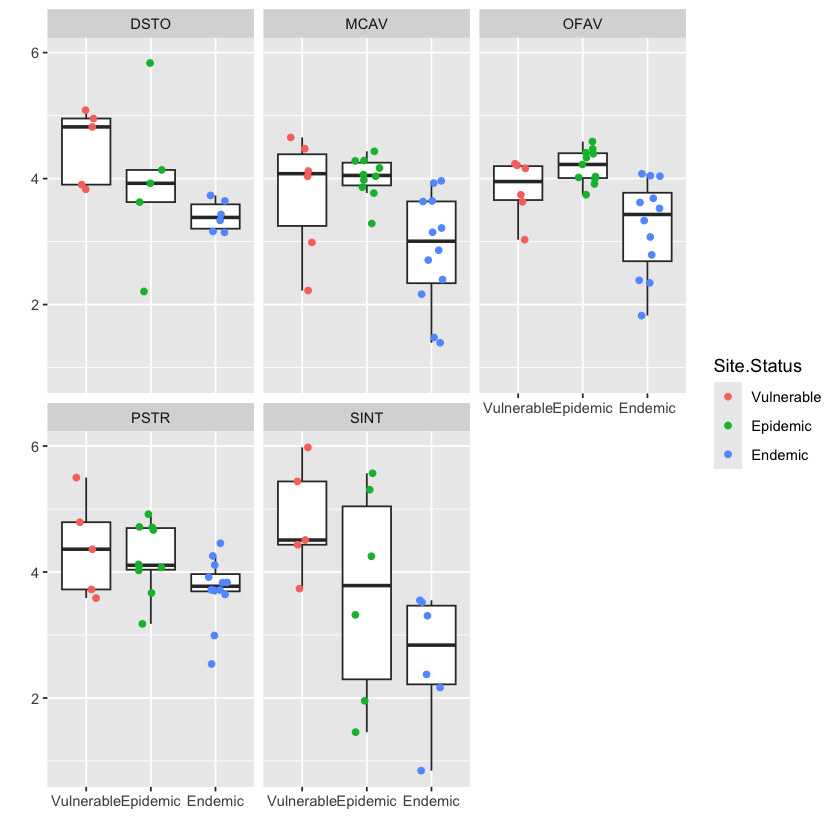

In [45]:
adiv_AH_z <- data.frame(
  "Shannon" = phyloseq::estimate_richness(ps_AH_rare, measures = "Shannon"))
head(adiv)

#combine data with enviornmental data
ps_AH_rare_meta= as(sample_data(ps_AH_rare), "data.frame")

head(ps_AH_rare_meta)

alpha_envs_AH_rare=cbind(ps_AH_rare_meta, adiv_AH_z)

alpha_envs_AH_rare %>%
 ggplot(aes(x = Site.Status, y = Shannon))  +
  geom_boxplot(outlier.color = NA)  +
geom_jitter(aes(color = Site.Status), height = 0, width = .2) +
  labs(x = "", y = "") +
facet_wrap(.~Species_sample)


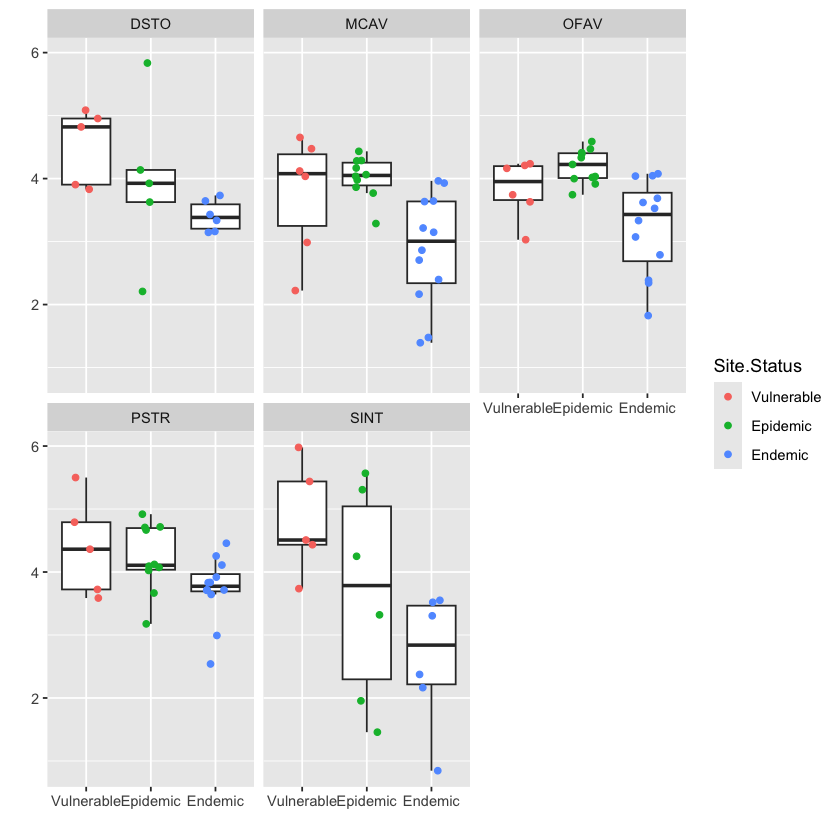

In [46]:
alpha_envs_AH_rare %>%
 ggplot(aes(x = Site.Status, y = Shannon))  +
  geom_boxplot(outlier.color = NA)  +
geom_jitter(aes(color = Site.Status), height = 0, width = .2) +
  labs(x = "", y = "") +
facet_wrap(.~Species_sample)

Warning message in phyloseq::estimate_richness(datasets[[i]]$ps, measures = "Shannon"):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


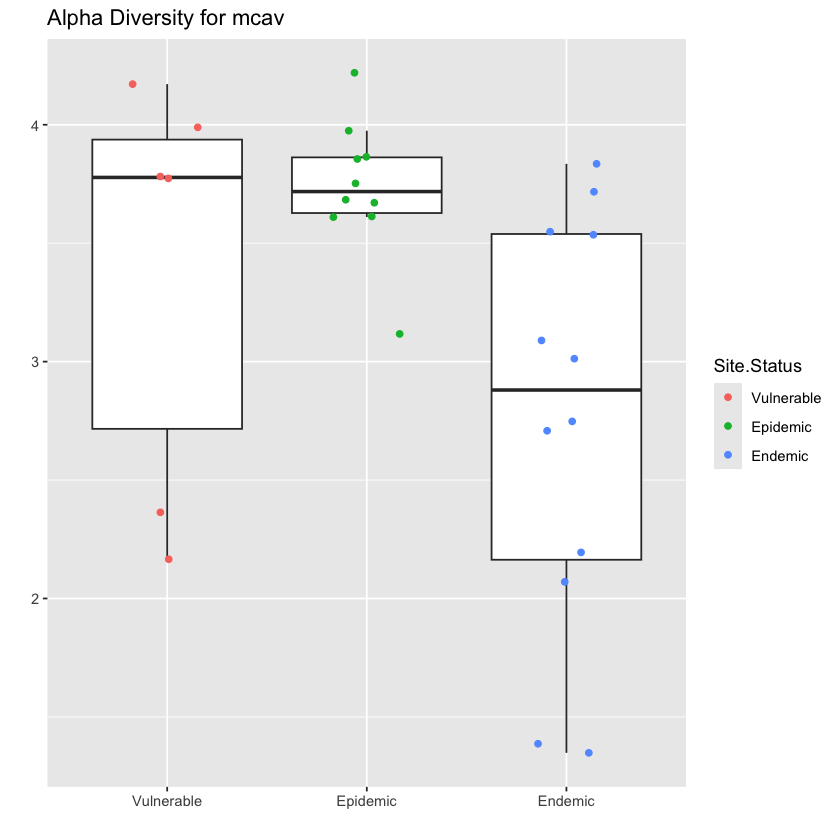

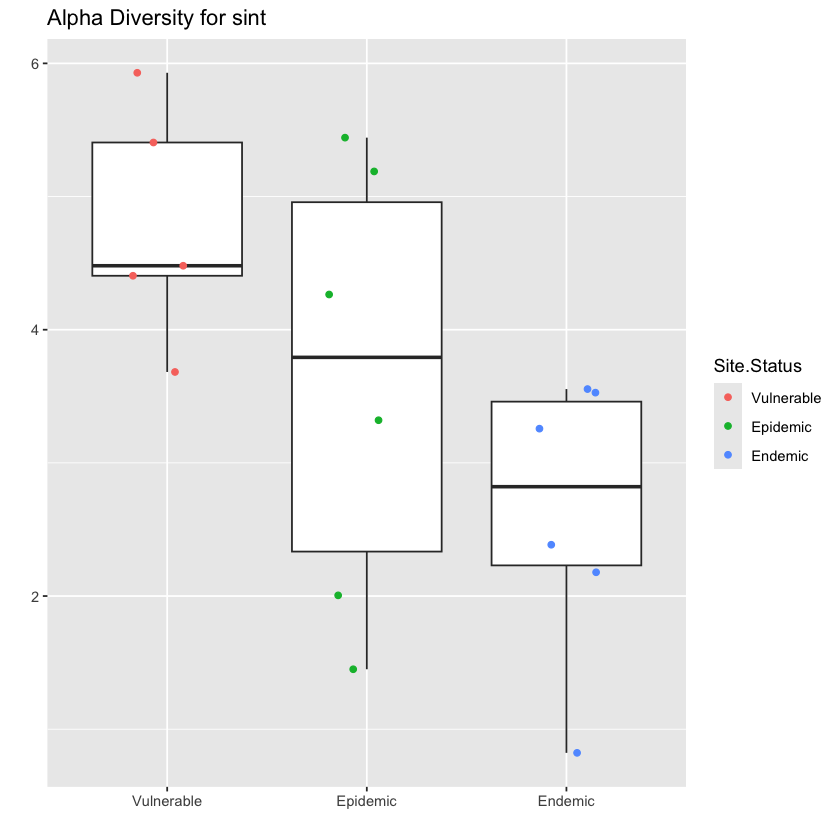

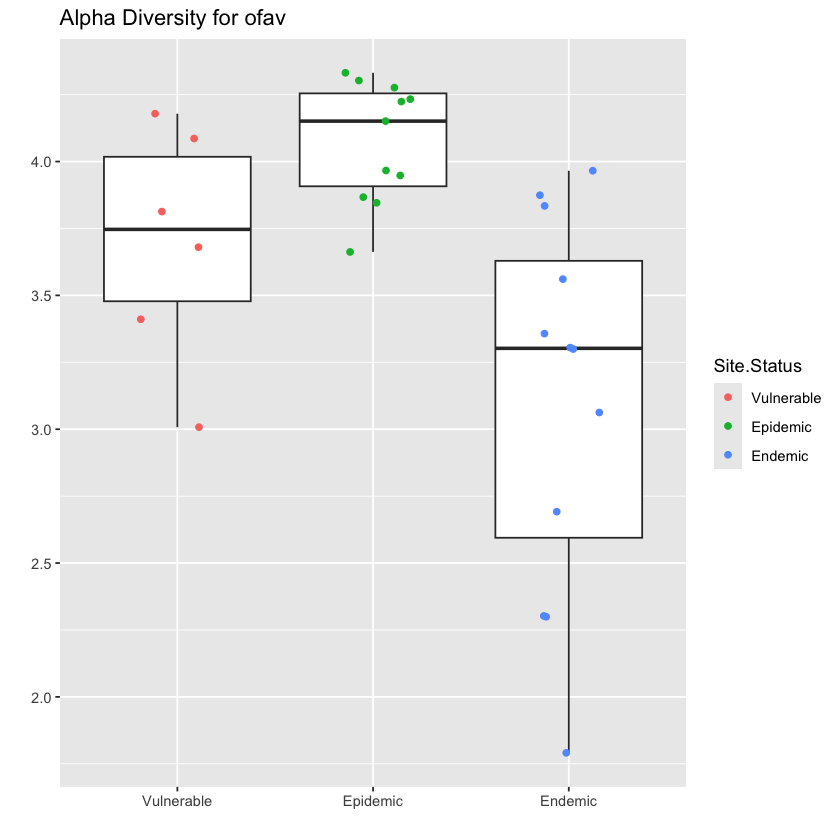

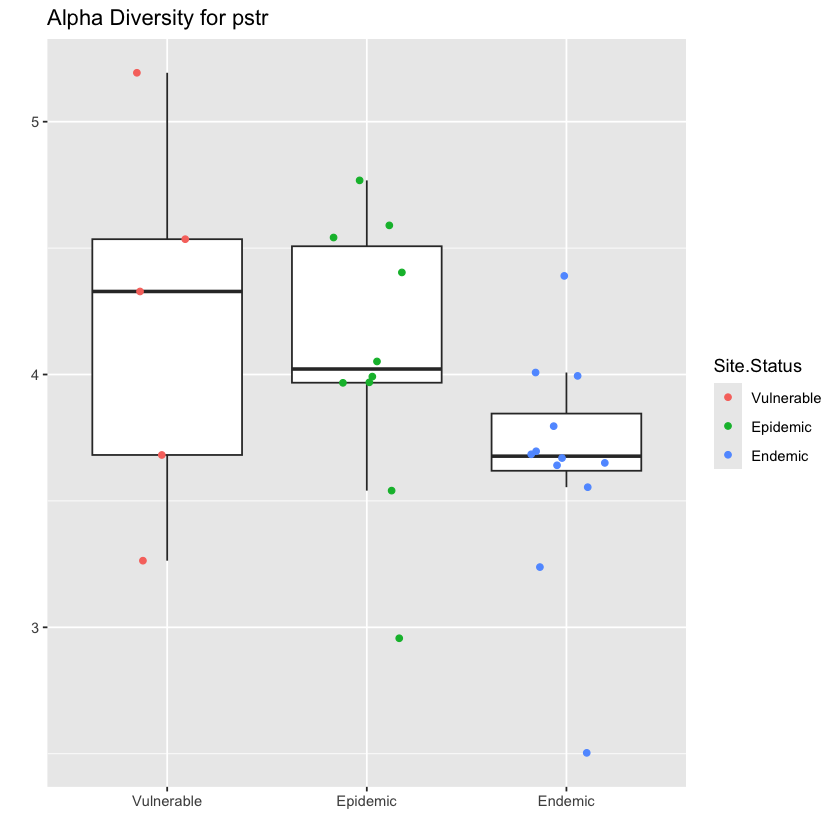

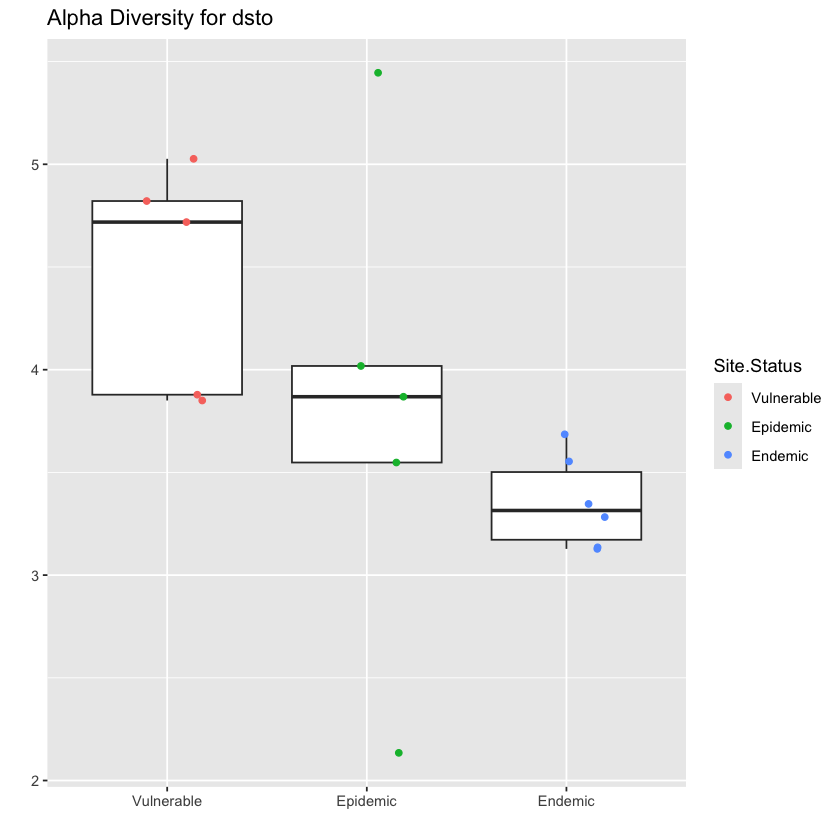

In [47]:
# Define a list of datasets and corresponding labels
datasets <- list(
  list(ps = ps_fill_mcav, label = "mcav"),
  list(ps = ps_fill_sint, label = "sint"),
    list(ps = ps_fill_ofav, label = "ofav"),
  list(ps = ps_fill_pstr, label = "pstr"),
    list(ps = ps_fill_dsto, label = "dsto")
)

# Initialize an empty list to store plots
plots <- list()

# Loop through each dataset
for (i in seq_along(datasets)) {
  # Compute alpha diversity
  adiv <- data.frame("Shannon" = phyloseq::estimate_richness(datasets[[i]]$ps, measures = "Shannon"))
  ps_ah_meta <- as(sample_data(datasets[[i]]$ps), "data.frame")
  alpha_ah <- cbind(ps_ah_meta, adiv)
  
  # Plot alpha diversity
  p <- alpha_ah %>%
    ggplot(aes(x = Site.Status, y = Shannon)) +
    geom_boxplot(outlier.color = NA) +
    geom_jitter(aes(color = Site.Status), height = 0, width = 0.2) +
    labs(x = "", y = "") +
    ggtitle(paste("Alpha Diversity for", datasets[[i]]$label))
  
  # Add plot to the list
  plots[[i]] <- p
}

# Print the plots
for (i in seq_along(plots)) {
  print(plots[[i]])
}


In [48]:
library(lsmeans)
library("GGally")
library("ggpmisc")
library(patchwork)
library(lsmeans)
library('pbkrtest')

Loading required package: emmeans


Attaching package: ‘emmeans’


The following object is masked from ‘package:GGally’:

    pigs


The 'lsmeans' package is now basically a front end for 'emmeans'.
Users are encouraged to switch the rest of the way.
See help('transition') for more information, including how to
convert old 'lsmeans' objects and scripts to work with 'emmeans'.

Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




## linear mixed models

In [103]:
packageVersion("lme4")
packageVersion("multcomp")

[1] ‘1.1.35.3’

[1] ‘1.4.25’

In [87]:
library(lme4)
library(lmerTest)
library(multcomp)
mixed.lmer_coral <- lmer(Shannon ~ Site.Status  + (1|Species_sample) + (1|Date), data = alpha_envs_AH_rare)
summary(mixed.lmer_coral)

posthoc <- glht(mixed.lmer_coral, linfct = mcp(Site.Status = "Tukey"))
summary(posthoc)
posthoc

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Shannon ~ Site.Status + (1 | Species_sample) + (1 | Date)
   Data: alpha_envs_AH_rare

REML criterion at convergence: 283.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0431 -0.4467  0.1647  0.5397  2.3962 

Random effects:
 Groups         Name        Variance Std.Dev.
 Date           (Intercept) 0.06165  0.2483  
 Species_sample (Intercept) 0.03572  0.1890  
 Residual                   0.60442  0.7774  
Number of obs: 117, groups:  Date, 8; Species_sample, 5

Fixed effects:
                    Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)           4.2213     0.2241  5.7945  18.837 2.03e-06 ***
Site.StatusEpidemic  -0.1756     0.2771  4.2606  -0.634   0.5586    
Site.StatusEndemic   -1.0147     0.3427  2.2711  -2.961   0.0838 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) St.SttsEp
St.


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = Shannon ~ Site.Status + (1 | Species_sample) + 
    (1 | Date), data = alpha_envs_AH_rare)

Linear Hypotheses:
                           Estimate Std. Error z value Pr(>|z|)   
Epidemic - Vulnerable == 0  -0.1756     0.2771  -0.634  0.80028   
Endemic - Vulnerable == 0   -1.0147     0.3427  -2.961  0.00837 **
Endemic - Epidemic == 0     -0.8390     0.3286  -2.554  0.02836 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



	 General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Linear Hypotheses:
                           Estimate
Epidemic - Vulnerable == 0  -0.1756
Endemic - Vulnerable == 0   -1.0147
Endemic - Epidemic == 0     -0.8390


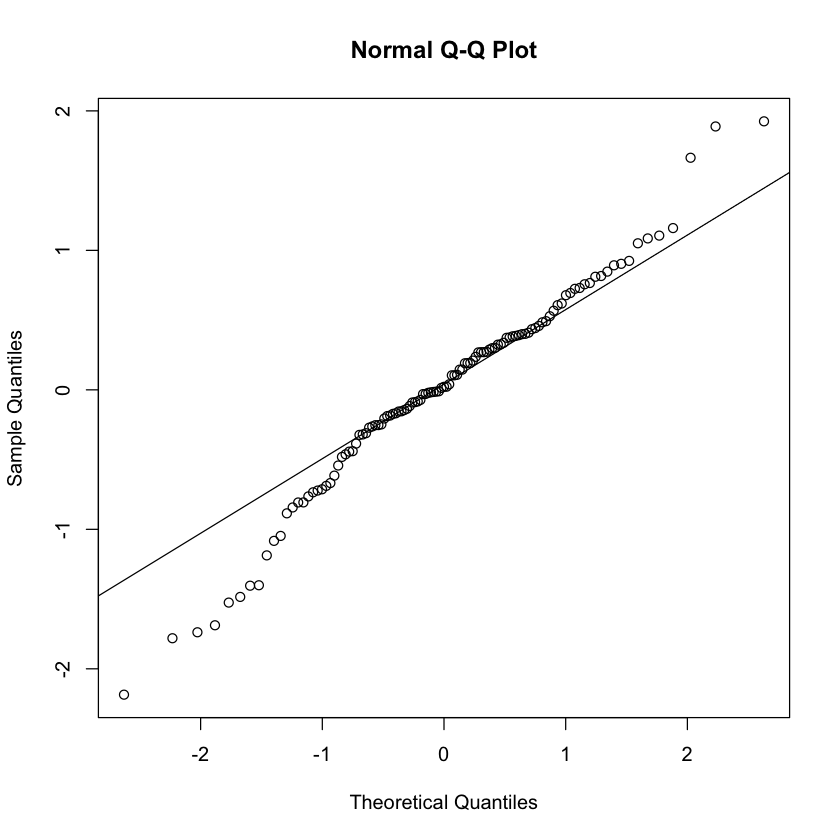

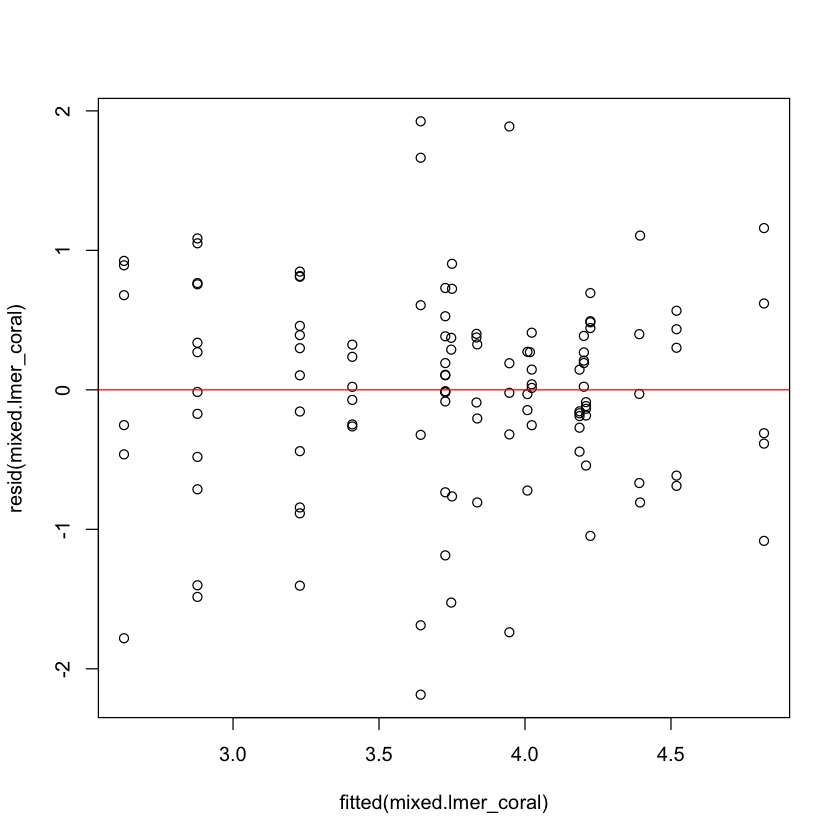

In [86]:
qqnorm(resid(mixed.lmer_coral))
qqline(resid(mixed.lmer_coral))

plot(fitted(mixed.lmer_coral), resid(mixed.lmer_coral))
abline(h = 0, col = "red")

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Shannon ~ Site.Status + (1 | Site.Name) + (1 | Date)
   Data: alpha_s_rare

REML criterion at convergence: -5.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1890 -0.4135  0.1137  0.4634  1.7858 

Random effects:
 Groups    Name        Variance Std.Dev.
 Date      (Intercept) 0.022620 0.15040 
 Site.Name (Intercept) 0.003372 0.05807 
 Residual              0.045490 0.21328 
Number of obs: 90, groups:  Date, 5; Site.Name, 3

Fixed effects:
                    Estimate Std. Error     df t value Pr(>|t|)   
(Intercept)           6.4061     0.1589 1.3709  40.307  0.00449 **
Site.StatusEpidemic   0.2613     0.1928 1.2310   1.355  0.37202   
Site.StatusEndemic    0.5286     0.1923 1.2191   2.749  0.18446   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) St.SttsEp
St.SttsEpdm -0.788          
St.SttsEndm -0.790  


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = Shannon ~ Site.Status + (1 | Site.Name) + (1 | 
    Date), data = alpha_s_rare)

Linear Hypotheses:
                           Estimate Std. Error z value Pr(>|z|)  
Epidemic - Vulnerable == 0   0.2613     0.1928   1.355   0.3631  
Endemic - Vulnerable == 0    0.5286     0.1923   2.749   0.0163 *
Endemic - Epidemic == 0      0.2673     0.1609   1.662   0.2188  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


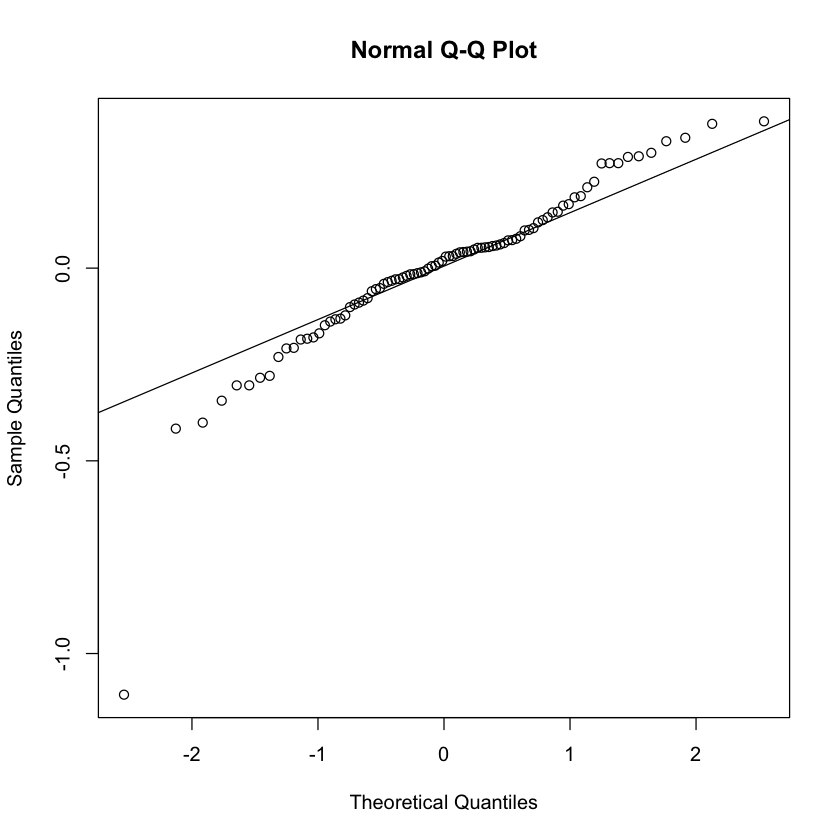

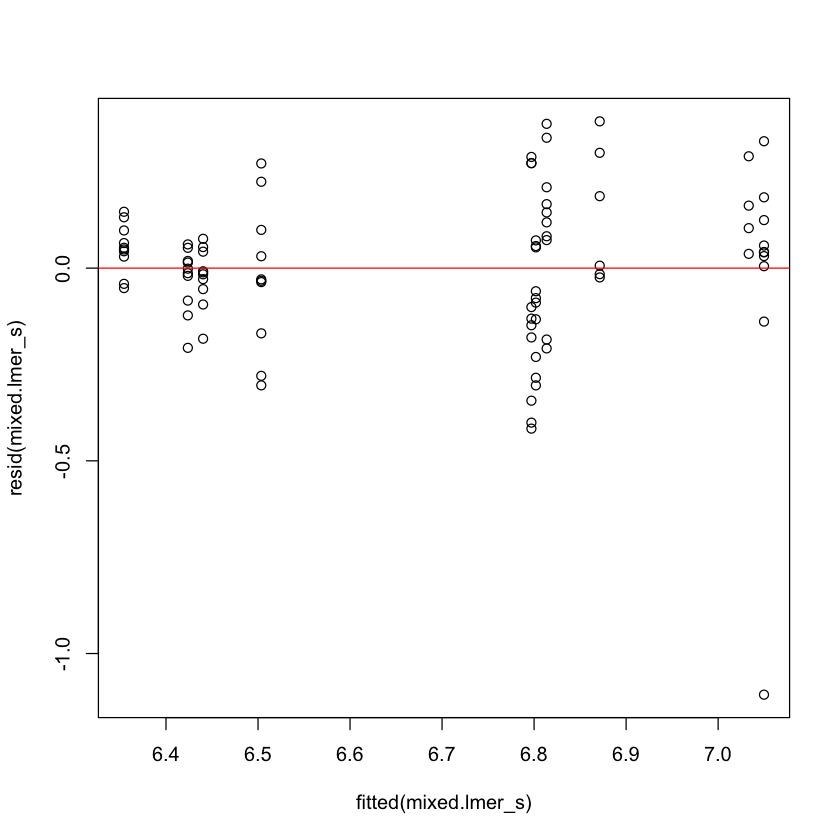

In [100]:
mixed.lmer_s <- lmer(Shannon ~ Site.Status  + (1|Site.Name) + (1|Date) , data =alpha_s_rare)
summary(mixed.lmer_s)

posthoc <- glht(mixed.lmer_s, linfct = mcp(Site.Status = "Tukey"))
summary(posthoc)


qqnorm(resid(mixed.lmer_s))
qqline(resid(mixed.lmer_s))

plot(fitted(mixed.lmer_s), resid(mixed.lmer_s))
abline(h = 0, col = "red")

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Shannon ~ Site.Status + (1 | Site.Name) + (1 | Date)
   Data: alpha_w_rare

REML criterion at convergence: -97.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8291 -0.4844 -0.0905  0.4907  3.9760 

Random effects:
 Groups    Name        Variance Std.Dev.
 Date      (Intercept) 0.054503 0.23346 
 Site.Name (Intercept) 0.006145 0.07839 
 Residual              0.015157 0.12311 
Number of obs: 96, groups:  Date, 7; Site.Name, 3

Fixed effects:
                    Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)           4.3779     0.1463 4.6809  29.917 1.58e-06 ***
Site.StatusEpidemic   0.2797     0.2172 3.8271   1.288    0.270    
Site.StatusEndemic    0.1218     0.2171 3.8200   0.561    0.606    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) St.SttsEp
St.SttsEpdm -0.609          
St.SttsEndm -0.


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = Shannon ~ Site.Status + (1 | Site.Name) + (1 | 
    Date), data = alpha_w_rare)

Linear Hypotheses:
                           Estimate Std. Error z value Pr(>|z|)
Epidemic - Vulnerable == 0   0.2797     0.2172   1.288    0.402
Endemic - Vulnerable == 0    0.1218     0.2171   0.561    0.841
Endemic - Epidemic == 0     -0.1579     0.2358  -0.670    0.781
(Adjusted p values reported -- single-step method)


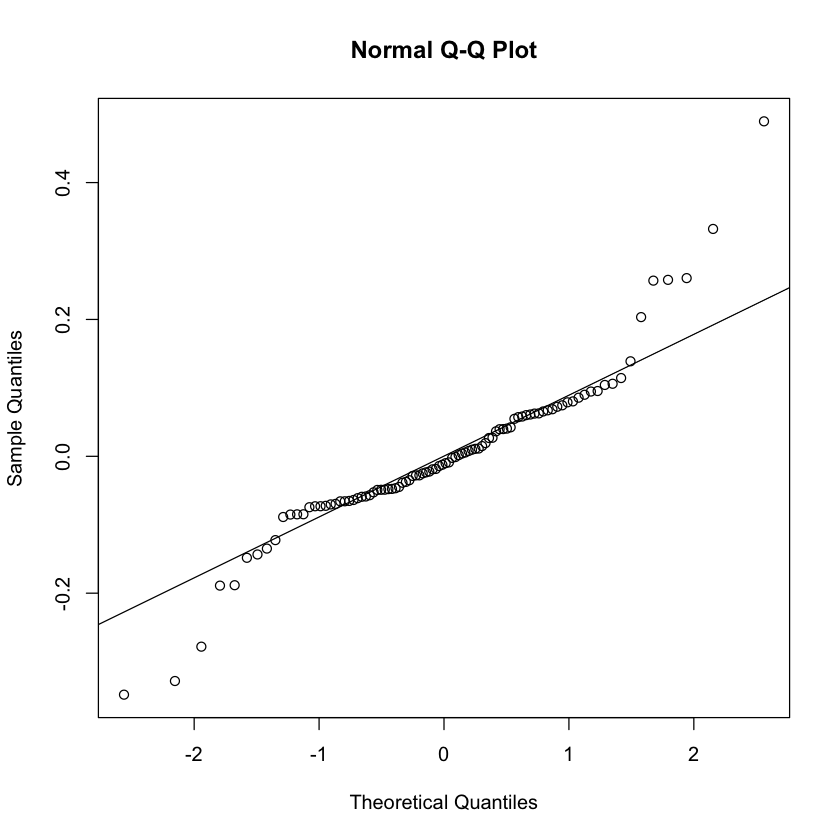

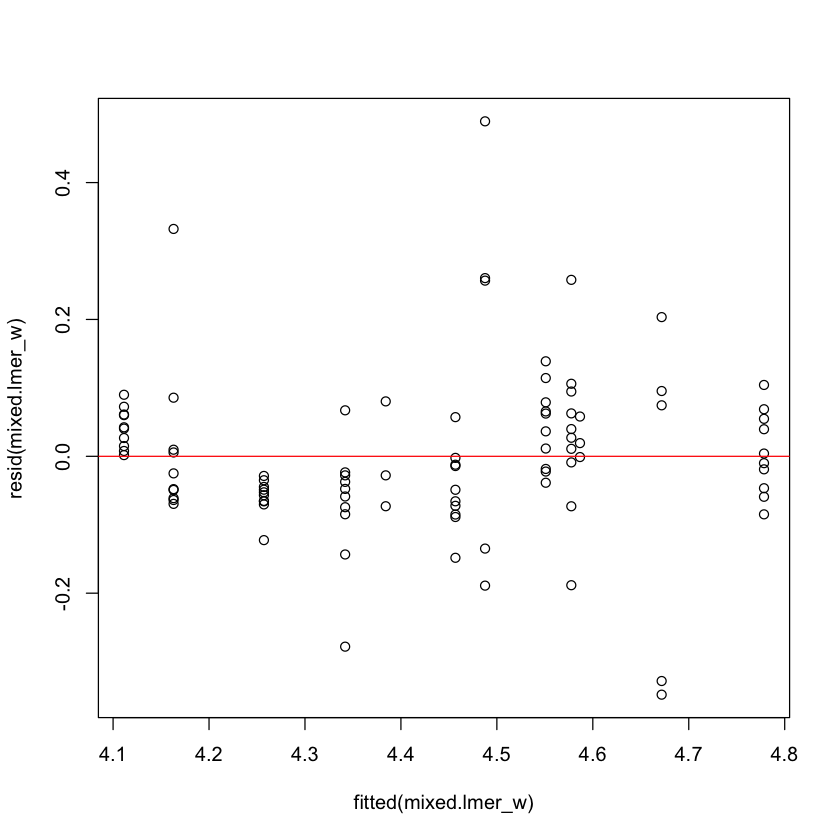

In [104]:
mixed.lmer_w <- lmer(Shannon ~ Site.Status  + (1|Site.Name) + (1|Date) , data =alpha_w_rare)
summary(mixed.lmer_w)

posthoc <- glht(mixed.lmer_w, linfct = mcp(Site.Status = "Tukey"))
summary(posthoc)


qqnorm(resid(mixed.lmer_w))
qqline(resid(mixed.lmer_w))

plot(fitted(mixed.lmer_w), resid(mixed.lmer_w))
abline(h = 0, col = "red")